In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from utils import *
from glob import glob
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter1d

In [3]:
basedir = '../matlab/tensors' #where to find the .mat files produced by the permuted tensor decomposition
tensorname = 'drifting_gratings_VISp_shiftdirs_p0.001_32xp_N1261' #input tensor base filename
preComputed,Fs = loadPreComputedCP(tensorname,basedir)

F2: (16) F3: (16) F4: (16) F5: (16) F6: (16) F7: (16) F8: (16) F9: (16) F10: (16) F11: (16) F12: (16) F13: (16) F14: (16) F15: (16) F16: (16) F17: (16) F18: (16) F19: (16) F20: (16) F21: (16) F22: (16) F23: (16) F24: (16) F25: (16) F26: (16) F27: (16) F28: (16) F29: (15) F30: (16) F31: (16) F32: (15) F33: (15) F34: (16) F35: (16) F36: (16) F37: (13) F38: (14) F39: (16) F40: (14)


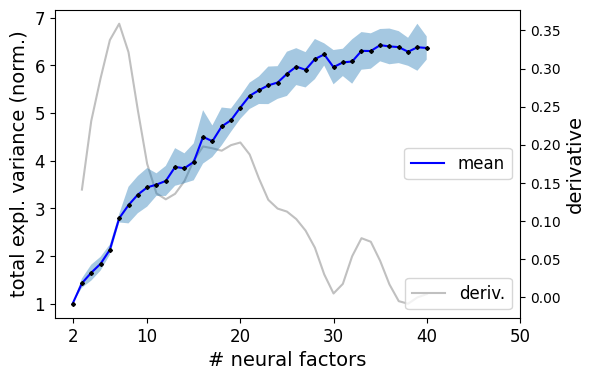

In [4]:
#plot total normalized explained variance (nuclear norm) for each F


nfacs = np.array(Fs)
NEURALMODE = 0
mus = []

stds = []

LGD_SZ = 12
LBL_SZ = 14
TICK_SZ = 12

for nf in nfacs:
    #collect factors for all available repetitions
    neuralfs = np.array([preComputed[nf]['all_factors'][repi][NEURALMODE] for repi in sorted(preComputed[nf]['all_factors'])])
    #normalize
    neuralfs = [f/from0to1(np.linalg.norm(f,axis=0,keepdims=1)) for f in neuralfs]
    
    nucl_norms = []
    
    reps_used = list(preComputed[nf]['all_lambdas'])###
    
    for repi in range(len(preComputed[nf]['all_factors'])):

        A = neuralfs[repi].copy()
        Si = A.T
        Si -= Si.mean(0)
        #compute explained variances
        s = np.linalg.svd(Si,full_matrices=False,compute_uv=False)
        var = s**2/(Si.shape[0]-1)   
        #normalize
        var /= var.max()
        # compute nuclear norm (sum of eigenvals)
        nucl_norms.append( var.sum() )

    mus.append(np.mean(nucl_norms))
    stds.append(np.std(nucl_norms))

f,ax1 = subps(1,1,4,6)
ax1.plot(nfacs, mus,'b-', label='mean')
ax1.plot(nfacs, mus,'kD',markersize=2)

mus = np.array(mus)
grads = np.diff(gaussian_filter1d(mus,1.5))
ax1_ = ax1.twinx()
ax1_.plot(nfacs[1:],grads,c='silver',label='deriv.',zorder=0)
ax1_.set_ylabel('derivative',size=LBL_SZ)
ax1_.legend(loc="lower right",fontsize=LGD_SZ)
stds = np.array(stds)
ax1.fill_between(nfacs,mus-stds,mus+stds,alpha=.4)
ax1.set_xlabel('# neural factors',size=LBL_SZ)
ax1.set_ylabel('total expl. variance (norm.)',size=LBL_SZ)
ax1.set_xticks([2]+list(range(10,51,10)))
ax1.tick_params(labelsize=TICK_SZ)
ax1.legend(loc="center right",fontsize=LGD_SZ)
ax1.set_zorder(ax1_.get_zorder()+1)
ax1.set_frame_on(False)

plt.show()

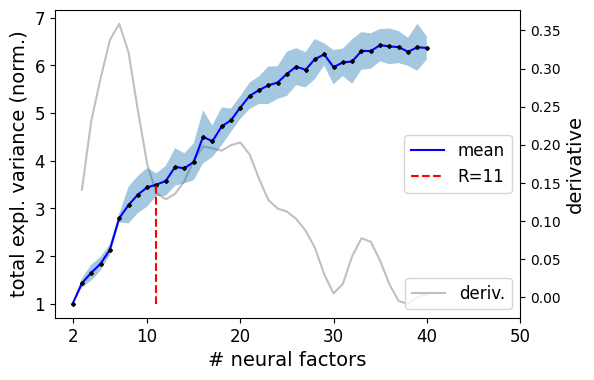

In [5]:
R = 11 #find this based on plot above
#replot, highlighting choice for "rank", R


f,ax1 = subps(1,1,4,6)
ax1.plot(nfacs, mus,'b-', label='mean')
ax1.plot(nfacs, mus,'kD',markersize=2)

mus = np.array(mus)
ax1.plot([R,R],[mus.min(),mus[list(nfacs).index(R)]],'r--',label=f'R={R}',zorder=10)
grads = np.diff(gaussian_filter1d(mus,1.5))
ax1_ = ax1.twinx()
ax1_.plot(nfacs[1:],grads,c='silver',label='deriv.',zorder=0)
ax1_.set_ylabel('derivative',size=LBL_SZ)
ax1_.legend(loc="lower right",fontsize=LGD_SZ)
stds = np.array(stds)
ax1.fill_between(nfacs,mus-stds,mus+stds,alpha=.4)
ax1.set_xlabel('# neural factors',size=LBL_SZ)
ax1.set_ylabel('total expl. variance (norm.)',size=LBL_SZ)
ax1.set_xticks([2]+list(range(10,51,10)))
ax1.tick_params(labelsize=TICK_SZ)
ax1.legend(loc="center right",fontsize=LGD_SZ)
ax1.set_zorder(ax1_.get_zorder()+1)
ax1.set_frame_on(False)

plt.show()

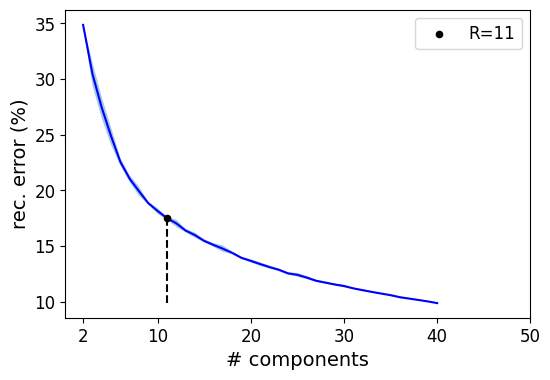

In [6]:
# plot mean error for each choice of F (number of components)
# (in general this is not very helpful to decide on R, so we use the approach above)

LBLSIZE = 14
LGD_SZ = 12
TICK_SZ = 12
LBL_SZ = 14

f,(ax) = subps(1,1,4,6)
objs = np.array([np.mean(list(preComputed[F]['all_objs'].values())) for F in Fs])
stds = np.array([np.std(list(preComputed[F]['all_objs'].values())) for F in Fs])
ax.plot(Fs,objs,'b-',)
ax.fill_between(Fs,objs-stds,objs+stds,alpha=.4)

ax.plot([R,R],[np.min(objs),objs[list(Fs).index(R)]],'k--')
ax.scatter([R],[objs[list(Fs).index(R)]],c='k',s=20,label=f'R={R}',zorder=5)

ax.legend(fontsize=LGD_SZ)
ax.tick_params(labelsize=TICK_SZ)
ax.set_ylabel('rec. error (%)',size=LBL_SZ)
ax.set_xlabel('# components',size=LBL_SZ)
ax.set_xticks([2]+list(range(10,51,10)))

plt.show()

In [7]:
rep, error = min(preComputed[R]['all_objs'].items(), key=lambda x: x[1])
print(f'The repetition with min error was #{rep} (% error = {error:.3f})')

The repetition with min error was #6 (% error = 17.239)


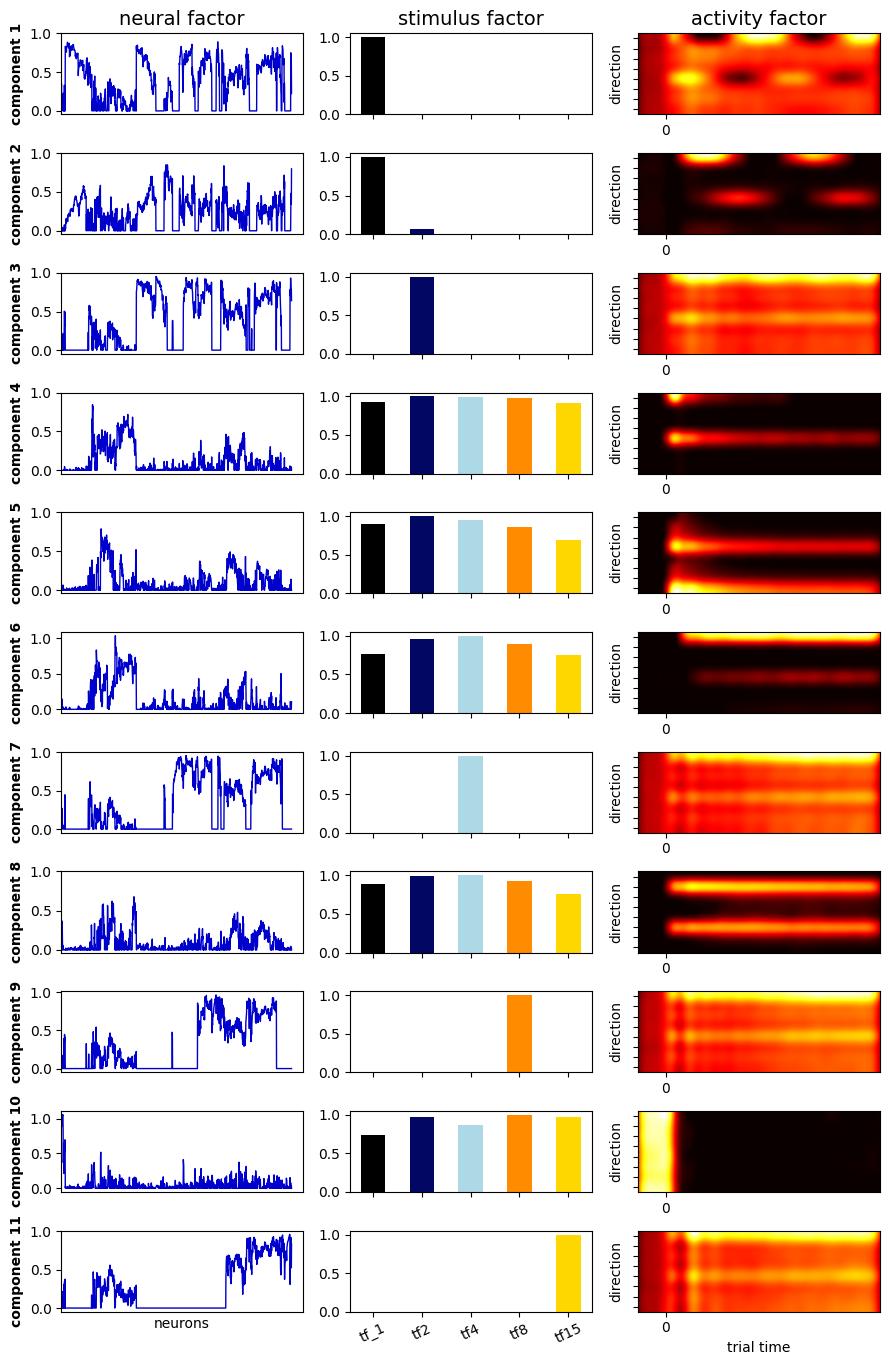

In [8]:
#PLOT FACTORS
from scipy.cluster.hierarchy import linkage,leaves_list,optimal_leaf_ordering
from scipy.spatial.distance import pdist

R = 11
rep = 6
best_factors = preComputed[R]['all_factors'][rep]
best_lambdas = preComputed[R]['all_lambdas'][rep]

# remove any eventual zero-norm factor
posnorms = ~np.isclose(best_lambdas,0)
lambdas = best_lambdas[posnorms]
# make sure they are all normalized
factors = [f[:,posnorms]/np.linalg.norm(f[:,posnorms],axis=0,keepdims=1) for f in best_factors]

posnorms = ~np.isclose(best_lambdas,0)
best_lambdas = best_lambdas[posnorms]
nfactors = [f[:,posnorms]/np.linalg.norm(f[:,posnorms],axis=0,keepdims=1) for f in best_factors]



my_stims = ['tf_1', 'tf2', 'tf4', 'tf8', 'tf15']

NSTIMS = len(my_stims)
NDIRS = 8


colors = ['k','xkcd:darkblue','lightblue','darkorange','gold']
assert len(colors) >= NSTIMS

ncols = 3; colsz = 3.
nrows = R; rowsz = 1.25

#sort factors by predominant stimulus (%)
sorted_factors_full = np.argsort((nfactors[1]).argmax(axis=0))


#rebalance factor loadings, scale by lambdas
stim_factors = nfactors[1].copy()
stim_scls = stim_factors.max(0,keepdims=1)
stim_factors /= stim_scls

neural_factors = nfactors[0].copy()
neural_factors *= best_lambdas
neural_factors *= stim_scls

#to improve visualization, find a global sorting of the neurons
# by running a hierarchical clustering based on the distance 
# between their neural coefficients across all components
flat_dist_mat = pdist(neural_factors)
Z = linkage(flat_dist_mat, method='complete')
leaves = leaves_list(optimal_leaf_ordering(Z, flat_dist_mat))

YLBL_SZ = 10
TITL_SZ = 14
COMP_SZ = 10
OPT_DIR = 0

start_bin = 25

lll = 0 #global count of components plotted so far

for fig_i,sorted_factors in enumerate([sorted_factors_full]):
    nrows = len(sorted_factors)
    fig,axes = plt.subplots(nrows,ncols,figsize=(colsz*ncols,nrows*rowsz))
    for ll,l in enumerate(sorted_factors):
        lll += 1
        ax = axes[ll,0]

        ax.set_ylabel(f'component {lll}', fontweight='bold', fontsize=COMP_SZ)

        ax.plot(neural_factors[leaves,l],lw=1,c='mediumblue')
        ax.set_xlim(0,ax.get_xlim()[1])
        ax.set_xticks([])
        if ll == 0:
            ax.set_title(f'neural factor',size=TITL_SZ)
        if l == sorted_factors[-1]:
            ax.set_xlabel('neurons')
        ax.set_yticks([0,.5,1.])
        ax.tick_params(axis='y', labelsize=YLBL_SZ)
        

        ax = axes[ll,1]
        ax.bar(range(NSTIMS),stim_factors[:,l],width=.5,
                color=colors)
        ax.set_xticks(range(NSTIMS))
        if l == sorted_factors[-1]:
            ax.set_xticklabels(my_stims)
            ax.tick_params(axis='x', labelrotation=25)
        else:
            ax.set_xticklabels(['']*NSTIMS)
        if ll == 0:
            ax.set_title(f'stimulus factor',size=TITL_SZ)
        ax.set_yticks([0,.5,1.])
        ax.tick_params(axis='y', labelsize=YLBL_SZ)

        ax = axes[ll,2]
        if ll == 0:
            ax.set_title(f'activity factor',size=TITL_SZ)
        pst = nfactors[2][:,l].reshape(NDIRS,-1,order='F')
        #circular-shift all response maps to same global opt dir (for better visualization)
        pst = np.roll(pst,(2-OPT_DIR)%NDIRS,0)

        ax.imshow(pst,aspect='auto',interpolation='quadric',cmap='hot',vmin=0)
        ax.set_yticks(range(NDIRS))
        ax.set_yticklabels(['']*NDIRS)
        ax.set_xticks([])
        ax.set_ylabel('direction');
        if l == sorted_factors[-1]:
            ax.set_xlabel('trial time')
        
        ax.set_xticks([start_bin])
        ax.set_xticklabels(['0'])
        ax.tick_params(axis='x', labelsize=YLBL_SZ)
    fig.tight_layout()
    plt.show()


In [10]:
np.save(f'tensor-data/{tensorname}_R{R}_factors.npy',best_factors)
np.save(f'tensor-data/{tensorname}_R{R}_lambdas.npy',best_lambdas)